In [9]:
import torch
import pandas as pd
import esm
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from Bio import SeqIO
import numpy as np

# Data prep


Open Non Core Pu file


In [6]:
with open("SET_PUs_NON_CORES (1).txt") as f:
    No_Pu = f.readlines()

for i in range(len(No_Pu)):
    No_Pu[i] = No_Pu[i].strip()

Open Fasta data


In [10]:
fasta_file = "DB_PU_NONPU_SEQ.fasta"
fasta_sequence = []
with open(fasta_file, "r") as f:
    for record in SeqIO.parse(f, "fasta"):
        fasta_sequence.append(record)

Open Pu File


In [11]:
Pu = pd.read_table(
    "LISTS_CATFS_PU_PROTOTYPE_with_fused_famillies (1)", sep="\t", header=None
)

In [12]:
data = []
for line in Pu[0]:
    liste = []

    line = line.split(" ")
    for element in line:
        if element != "":
            liste.append(element)
    data.append(liste)

In [13]:
SUPERFAMILLY = []
CLASS_ARCHITECTURE = []
TOPOLOGY = []
GROUP_LENGHT = []
PROTO_FOLD_group_ID = []
FREQUENCY = []
PROTO_FOLD_PROTOTYPE = []
PU_FAMILY_MEMBERS_CATEGORY = []
for element in data[7:]:
    SUPERFAMILLY.append(element[0])
    CLASS_ARCHITECTURE.append(element[1])
    TOPOLOGY.append(element[2])
    GROUP_LENGHT.append(element[3].split(".")[0])
    PROTO_FOLD_group_ID.append(element[3].split(".")[1])
    FREQUENCY.append(element[4])
    PROTO_FOLD_PROTOTYPE.append(element[5])
    PU_FAMILY_MEMBERS_CATEGORY.append(element[6:])

In [14]:
d = {
    "SUPERFAMILLY": SUPERFAMILLY,
    "CLASS_ARCHITECTURE": CLASS_ARCHITECTURE,
    "TOPOLOGY": TOPOLOGY,
    "GROUP_LENGHT": GROUP_LENGHT,
    "PROTO_FOLD_group_ID": PROTO_FOLD_group_ID,
    "FREQUENCY": FREQUENCY,
    "PROTO_FOLD_PROTOTYPE": PROTO_FOLD_PROTOTYPE,
    "PU_FAMILY_MEMBERS_CATEGORY": PU_FAMILY_MEMBERS_CATEGORY,
}

In [15]:
Pu_families = pd.DataFrame(data=d)

Set data labels


In [16]:
Sequence = []
Is_pu = []
file = []
for record in fasta_sequence:
    Sequence.append(str(record.seq))
    file_name = f'{record.id}_{record.description.split("|")[1].split(" ")[1].split(":")[1]}_{record.description.split("|")[2].split(" ")[1].split(":")[1]}_{record.description.split("|")[3].split(" ")[1].split(":")[1]}'
    file.append(file_name)
    if file_name in No_Pu:
        Is_pu.append(0)
    elif file_name in Pu_families["PROTO_FOLD_PROTOTYPE"].values:
        Is_pu.append(1)
    else:
        Is_pu.append(2)

In [17]:
d = {"Sequence": Sequence, "Is_pu": Is_pu, "file": file}

In [18]:
seq_data = pd.DataFrame(data=d)

In [19]:
seq_data.loc[seq_data["Is_pu"] == 0]

,Sequence,Is_pu,file
134,DLFSALPTNADLYRECKFL,0,16VPA_10_41_59
173,HGDVAFPTLPATRDGL,0,16VPA_12_85_100
181,FDCLCCDLESWRQLAGLFQP,0,16VPA_13_207_226
274,AALEPTDSGAPSAIVMFPVGEKPNPKGAAMKPVVFNHLIHEKKIA,0,19HCA_10_1_45
277,EILCATCHHRSPLSLTPP,0,19HCA_10_222_239
...,...,...,...
400404,EGKFTEEVMVNFVTKEGNLPDPTNYFDFDSIYWSVNRSKSDVSYGD...,0,2JJQA_10_166_219
403207,LDPQQPIFTVPGCISATPISDILDAQLPTWGQSLTSGATLLHNKQP...,0,2NPIA_12_143_196
405713,ESTYGGFSNVIFEKSVPTPQLLRDVPDDEEYVPSVLYGCTCDGVDV...,0,2NVAA_10_281_335
409607,KVYQFDFGSGSMEPGYIGVRASDRYDRSKGYGFQTPENMRDVAASG...,0,2O14A_7_1_55


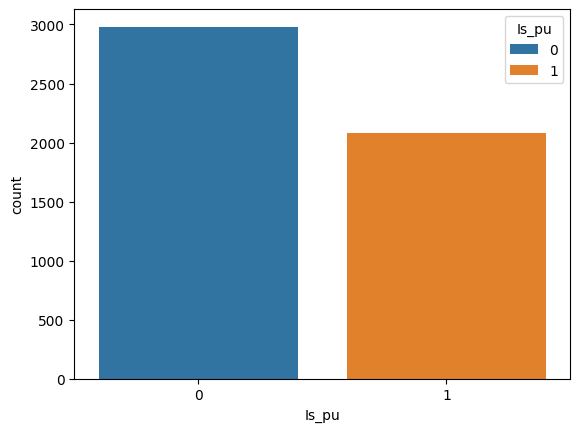

In [20]:
# Count on pu and non pu


sns.countplot(x="Is_pu", data=seq_data.loc[(seq_data["Is_pu"] != 2)], hue="Is_pu")
plt.show()

Data for embedding


In [21]:
pre_emb_pu = seq_data.loc[(seq_data["Is_pu"] == 1)][["Sequence", "file"]]
pre_emb_nonpu = seq_data.loc[(seq_data["Is_pu"] == 0)][["Sequence", "file"]]

Transformers


In [22]:
EMB_PATH_PU = "./embeddings/pu"
EMB_PATH_NONPU = "./embeddings/nonpu"

In [23]:
def embedding_preparation(pre_emb, EMB_PATH):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

    batch_converter = alphabet.get_batch_converter()

    model.eval()  # disables dropout for deterministic results

    for line in pre_emb.values:
        # Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

        data = [(line[1], line[0])]

        batch_labels, batch_strs, batch_tokens = batch_converter(data)

        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        # Extract per-residue representations (on CPU)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33], return_contacts=True)

            torch.save(results, f"{EMB_PATH}/{line[1]}.pt")

In [24]:
embedding_preparation(pre_emb_pu, EMB_PATH_PU)
embedding_preparation(pre_emb_nonpu, EMB_PATH_NONPU)

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /Users/mathisreineat-40/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /Users/mathisreineat-40/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [25]:
def padding(tensor, max_size):
    if tensor.numpy().shape[0] < max_size:
        padding = max_size - tensor.numpy().shape[0]
        tensor = tf.pad(tensor, ((0, padding), (0, 0)))
    return tensor

In [26]:
# List of all embeddings
def get_embedding_list(PATH, label, max_size):
    list_of_embeddings = []
    for filename in os.listdir(PATH):
        embedding_dict = torch.load(os.path.join(PATH, filename))["representations"][
            33
        ][0]

        embedding_tensor = tf.convert_to_tensor(embedding_dict)
        embedding_tensor = padding(embedding_tensor, max_size)
        list_of_embeddings.append(embedding_tensor)
    return list_of_embeddings, [label] * len(list_of_embeddings)

In [104]:
batch_size = 200

In [27]:
pd_non_pu, label_non_pu = get_embedding_list(EMB_PATH_NONPU, 0, 62)
pd_pu, label_pu = get_embedding_list(EMB_PATH_PU, 1, 62)

In [28]:
embeddings = pd_non_pu + pd_pu
labels = label_non_pu + label_pu

In [29]:
# Split data into train and validation
from sklearn.model_selection import train_test_split

train_set, val_set, train_labels, val_labels = train_test_split(
    embeddings, labels, test_size=0.2
)

In [30]:
def conv_data(data, labels):
    return tf.data.Dataset.from_tensor_slices((data, labels))

In [31]:
def prep_data(train, lab, batch_size):
    tf_dataset = conv_data(train, lab)
    tf_dataset = tf_dataset.batch(batch_size)
    tf_dataset = tf_dataset.prefetch(tf.data.AUTOTUNE)
    return tf_dataset

In [108]:
tf_dataset = prep_data(train_set, train_labels, batch_size)
tf_val_dataset = prep_data(val_set, val_labels, batch_size)

Tensorflow model:

Protein classification


In [33]:
# Compute class weights


class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(train_labels), y=train_labels
)
class_weights = dict(enumerate(class_weights))

In [109]:
model_tf = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(62, 1280)),
        tf.keras.layers.GRU(300, return_sequences=True, dropout=0.3),
        tf.keras.layers.GRU(200, return_sequences=True, dropout=0.5),
        tf.keras.layers.GRU(124, dropout=0.1),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_tf.summary()
model_tf.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    
)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_34 (GRU)                (None, 62, 300)           1423800   
                                                                 
 gru_35 (GRU)                (None, 62, 200)           301200    
                                                                 
 gru_36 (GRU)                (None, 124)               121272    
                                                                 
 dense_20 (Dense)            (None, 2)                 250       
                                                                 
Total params: 1846522 (7.04 MB)
Trainable params: 1846522 (7.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [110]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

model_tf.fit(
    tf_dataset,
    epochs=500,
    validation_data=tf_val_dataset,
    callbacks=callback,
    class_weight=class_weights,
    batch_size = batch_size,

)

Epoch 1/500
21/21 [==============================] - 16s 652ms/step - loss: 0.6903 - accuracy: 0.5777 - val_loss: 0.6818 - val_accuracy: 0.6071
Epoch 2/500
21/21 [==============================] - 13s 631ms/step - loss: 0.6806 - accuracy: 0.5115 - val_loss: 0.6793 - val_accuracy: 0.4857
Epoch 3/500
21/21 [==============================] - 13s 634ms/step - loss: 0.6684 - accuracy: 0.5204 - val_loss: 0.6821 - val_accuracy: 0.5123
Epoch 4/500
21/21 [==============================] - 13s 619ms/step - loss: 0.6501 - accuracy: 0.5522 - val_loss: 0.6664 - val_accuracy: 0.5548
Epoch 5/500
21/21 [==============================] - 13s 628ms/step - loss: 0.6064 - accuracy: 0.6308 - val_loss: 0.6107 - val_accuracy: 0.6861
Epoch 6/500
21/21 [==============================] - 14s 642ms/step - loss: 0.5590 - accuracy: 0.7170 - val_loss: 0.6164 - val_accuracy: 0.6634
Epoch 7/500
21/21 [==============================] - 13s 634ms/step - loss: 0.5319 - accuracy: 0.7320 - val_loss: 0.5945 - val_accuracy:

In [36]:
def plot_history(history, metric):
    plt.plot(history.history[f"{metric}"])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f"model {metric}")
    plt.legend(["train", "test"], loc="upper left")
    plt.ylabel(f"{metric}")
    plt.xlabel("epoch")
    plt.show()

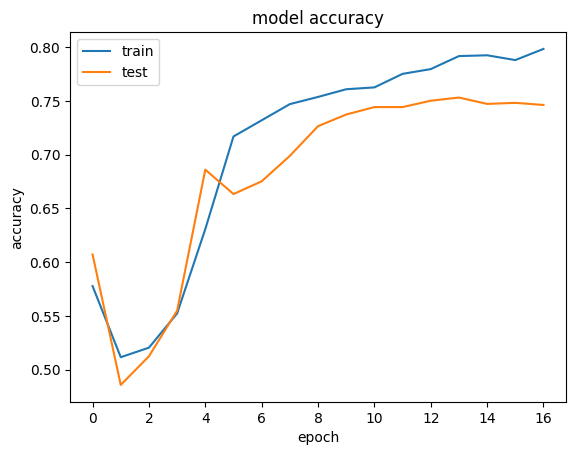

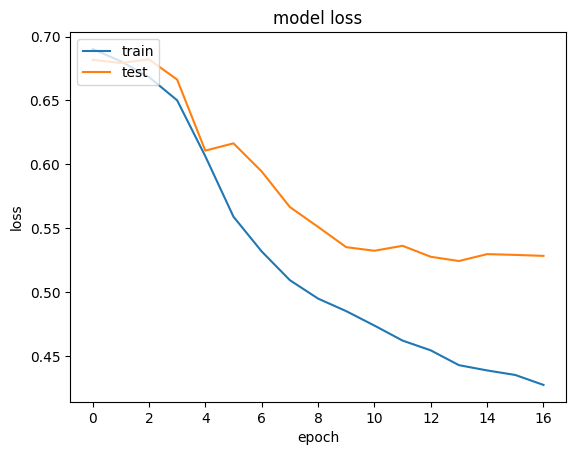

In [111]:
plot_history(model_tf.history, "accuracy")
plot_history(model_tf.history, "loss")

16/16 [==============================] - 2s 105ms/step


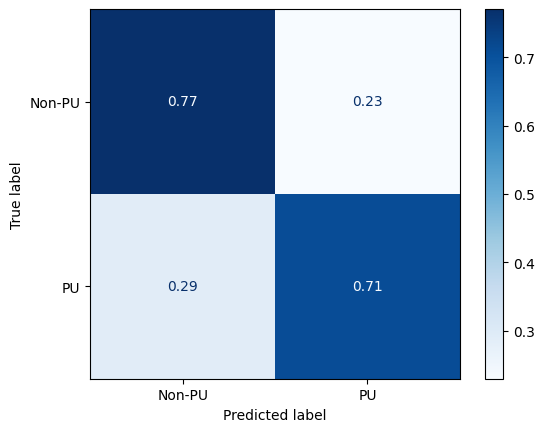

In [112]:
ConfusionMatrixDisplay.from_predictions(
    val_labels,
    model_tf.predict(prep_data(val_set, val_labels, 64)).argmax(axis=1),
    cmap="Blues",
    normalize="true",
    display_labels=["Non-PU", "PU"],
)
plt.show()

In [66]:
# Compute balanced accuracy

print(
    "Balanced accuracy: ",
    balanced_accuracy_score(
        val_labels, model_tf.predict(prep_data(val_set, val_labels, 64)).argmax(axis=1)
    ),
)

16/16 [==============================] - 1s 66ms/step
Balanced accuracy:  0.7384682385350834


In [40]:
EMB_UNKOWN = "./embeddings/unknown"
unknown = seq_data.loc[(seq_data["Is_pu"] == 2)][["Sequence", "file"]]

In [ ]:
embedding_preparation(unknown, EMB_UNKOWN)

In [42]:
tensor_unknown = tf.convert_to_tensor(
    torch.load(EMB_UNKOWN + "/1A0CA_1_1_385.pt")["representations"][33][0]
)

In [43]:
set_unknown = tf.data.Dataset.from_tensor_slices(
    (tensor_unknown, [2] * len(tensor_unknown))
)
set_unknown = set_unknown.batch(128)
set_unknown = set_unknown.prefetch(tf.data.AUTOTUNE)

In [46]:
len(set_unknown)


4

In [57]:

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_tensor=pd_pu[0],batch),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(124, activation="relu"),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.summary()
model.compile(
    
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (62, 300)                 384300    
                                                                 
 dense_9 (Dense)             (62, 124)                 37324     
                                                                 
 dense_10 (Dense)            (62, 2)                   250       
                                                                 
Total params: 421874 (1.61 MB)
Trainable params: 421874 (1.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model.fit(
    train_set,
    train_labels,
    epochs=500,
    validation_data=(val_set, val_labels),
    callbacks=callback,
    class_weight=class_weights,
)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'tensorflow.python.framework.ops.EagerTensor'>"}), (<class 'list'> containing values of types {"<class 'int'>"})